# Quantifying the World: Case Study 6
Eric Romero, Patricia Attah, Antonio Debouse

### Table of Contents:

   * <a href="#1"> Business Understanding </a>
   * <a href="#2"> Data Evaluation/Engineering </a>
   * <a href="#3"> Modeling Preparations </a>
   * <a href="#4"> Model Building and Evaluation </a>
   * <a href="#5"> Model Interpretability and Explainability </a>
   * <a href="#6"> Case Conclusions </a>

<a id="1"></a>
## Business Understanding


### Task Summary:
* Build a dense neural network to accurately detect the particle. 
* The goal is to maximize your accuracy. 
* Include a discussion of how you know your model has finished training as well as what design decisions you made while building the network. 

Business Objective:  
 
We were requested to build a dense neural network to detect a new particle based on a binary classification were 1 symbolizes a detection and 0 means non-detection. Accuracy is the measurement we will use, and the goal will be to create the most accurate prediction model.  

<a id="2"></a>
## Data Evaluation / Engineering

1. Checked for missing values 
2. Checked for correlations
3. Check for unbalanced target values
4. Checked VIF
5. Checked and removed Outliers
6. Checked and Removed highly correclated variables

We were given a massive dataset of 7 million observations with 29 columns, and fortunately no missing data and no concerns about multicollinearity. The variation is minimum within the columns as most of their standard deviations are close to only 1. Our targeted variable is the “Particle” column that is a balanced split of close to 50% “1s” and 50% “0s”. Given the massive dataset and the previously stated observations, we decided to use only 10% of the data for so our models could run quicker. 

We first look at the target variables to see if the data is unbalanced as this may alter our final deciding metric, but seeing our target variable is balanced we know know that accuracy can be used to help to determine the effectiveness of our model. After looking at the heatmap for correlations we found that f14/f18, f14/f26, f14/f10, f10/f26, f10/f6, and f22/f23 in particular were highly correlated to each other. The VIF is was then run to see how much each of these correlations affect the full model. It is standard that VIF above 5.0 is not accepatble, so we see that only f6 and f26 are above 5.0. Before removing these variables we also check to for any outliers that need to be adjusted, which may also correct the model VIF. F21 and f24 were identified as outliers, removal of these variables provided no substantial change to the VIF of the model. Therefore for the above reasons we are removing the f6, f21, f24, and f26 feautures and accepting all other features as important to our model.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import average_precision_score
import seaborn as sns
import sklearn.metrics

from sklearn.metrics import precision_recall_curve,f1_score
#from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve, roc_curve,roc_auc_score
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn.metrics import confusion_matrix
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import metrics as mt
import matplotlib.pyplot as pyplot

In [2]:
df_full = pd.read_csv('all_train.csv') #full data set
df_full.shape

(7000000, 29)

In [3]:
df = df_full.head(700000) #reduced set 10% of data
df.shape

(700000, 29)

In [4]:
df.rename(columns={'# label': 'particle'}, inplace=True)
df_full.rename(columns={'# label': 'particle'}, inplace=True)

In [5]:
df.head(5)

,particle,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f18,f19,f20,f21,f22,f23,f24,f25,f26,mass
0,1.0,-0.346368,0.416306,0.999236,0.475342,0.427493,-0.005984,1.989833,0.344530,1.566297,...,4.105282,0.267826,0.378718,1.743123,3.406367,4.350537,-0.352571,1.130032,2.227706,1000.0
1,1.0,1.708236,-0.319394,-1.241873,-0.887231,-0.871906,-0.005984,-0.001047,-1.038225,0.655748,...,-1.178141,-0.877361,-1.483769,-0.573682,-1.693781,-0.545062,-0.299118,-0.662942,-0.193019,750.0
2,0.0,-0.360693,1.794174,0.264738,-0.472273,-0.292344,-1.054221,-1.150495,1.423404,1.270098,...,-1.199511,0.539020,-1.590629,-0.573682,-0.543636,-0.937456,-0.300344,-0.523262,-1.506304,750.0
3,1.0,-0.377914,-0.103932,-0.649434,-2.125015,-1.643797,-0.005984,1.011112,-1.040340,-0.541991,...,0.463763,-0.006583,1.089122,-0.573682,-0.276348,-0.409272,-0.349926,-0.307123,0.529698,1250.0
4,0.0,-0.067436,-0.636762,-0.620166,-0.062551,1.588715,-0.005984,-0.595304,-1.238987,0.336844,...,-0.552837,-1.418494,-0.562982,1.743123,0.881802,0.002516,1.560950,-0.150760,-1.023889,750.0


In [6]:
for c in df.columns:
    print('{} is formatted as a(n) {}'.format(c, df[c].dtype))

particle is formatted as a(n) float64
f0 is formatted as a(n) float64
f1 is formatted as a(n) float64
f2 is formatted as a(n) float64
f3 is formatted as a(n) float64
f4 is formatted as a(n) float64
f5 is formatted as a(n) float64
f6 is formatted as a(n) float64
f7 is formatted as a(n) float64
f8 is formatted as a(n) float64
f9 is formatted as a(n) float64
f10 is formatted as a(n) float64
f11 is formatted as a(n) float64
f12 is formatted as a(n) float64
f13 is formatted as a(n) float64
f14 is formatted as a(n) float64
f15 is formatted as a(n) float64
f16 is formatted as a(n) float64
f17 is formatted as a(n) float64
f18 is formatted as a(n) float64
f19 is formatted as a(n) float64
f20 is formatted as a(n) float64
f21 is formatted as a(n) float64
f22 is formatted as a(n) float64
f23 is formatted as a(n) float64
f24 is formatted as a(n) float64
f25 is formatted as a(n) float64
f26 is formatted as a(n) float64
mass is formatted as a(n) float64


In [7]:
df.describe()

,particle,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f18,f19,f20,f21,f22,f23,f24,f25,f26,mass
count,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,...,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000
mean,0.500194,0.014299,-0.001821,-0.000500,0.011065,-0.000695,0.003151,0.017665,-0.001010,0.000558,...,0.012569,-0.000832,-0.000154,-0.001319,0.010597,0.009609,0.005516,-0.002753,0.015554,999.985351
std,0.500000,1.004928,0.997017,1.000194,0.994944,1.000547,1.000346,0.986640,0.996451,0.999598,...,1.003540,0.999622,1.000496,0.999228,1.009180,1.003724,1.008898,0.984363,0.983093,353.332738
min,0.000000,-1.960521,-2.365346,-1.732165,-9.980274,-1.732126,-1.054221,-2.717156,-2.757807,-1.732348,...,-1.728263,-2.281836,-1.731758,-0.573682,-3.556914,-3.608239,-20.622229,-2.818775,-2.622245,499.999969
25%,0.000000,-0.730980,-0.735855,-0.867137,-0.607982,-0.866129,-1.054221,-0.757353,-0.701229,-0.864430,...,-0.742695,-0.721645,-0.866922,-0.573682,-0.542972,-0.511450,-0.354324,-0.692639,-0.795915,750.000000
50%,1.000000,-0.043429,-0.001174,-0.000963,0.021551,-0.002218,-0.005984,-0.150231,-0.002847,0.003668,...,-0.087625,-0.000917,-0.000793,-0.573682,-0.161252,-0.314498,-0.326452,-0.358204,-0.087445,1000.000000
75%,1.000000,0.687176,0.731689,0.866430,0.679751,0.865264,0.850488,0.768819,0.699253,0.865523,...,0.641195,0.719308,0.866949,-0.573682,0.479096,0.164305,-0.233417,0.473007,0.760417,1250.000000
max,1.000000,3.946987,2.365145,1.732370,3.462227,1.731978,4.482618,3.536563,2.758590,1.731450,...,5.760416,2.282209,1.732734,1.743123,7.261469,9.193043,13.871066,4.446563,4.344859,1500.000000


In [8]:
#Checking for missing values
df.isnull().sum()

particle    0
f0          0
f1          0
f2          0
f3          0
f4          0
f5          0
f6          0
f7          0
f8          0
f9          0
f10         0
f11         0
f12         0
f13         0
f14         0
f15         0
f16         0
f17         0
f18         0
f19         0
f20         0
f21         0
f22         0
f23         0
f24         0
f25         0
f26         0
mass        0
dtype: int64

In [9]:
df_full['particle'].value_counts() #count for target feature of reduced set

1.0    3500879
0.0    3499121
Name: particle, dtype: int64

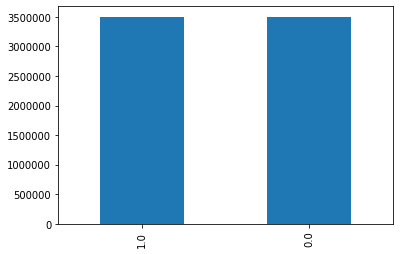

In [10]:
df_full['particle'].value_counts().plot(kind='bar');

In [11]:
df['particle'].value_counts() #count for target feature of reduced set displays approximately same distribution as full set

1.0    350136
0.0    349864
Name: particle, dtype: int64

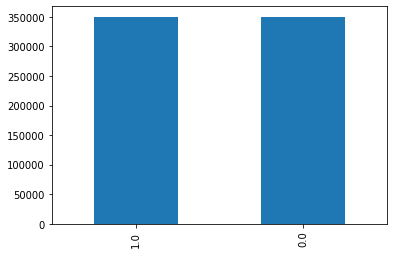

In [12]:
# checking the balance of the target variables - it is well balanced
df['particle'].value_counts().plot(kind='bar');

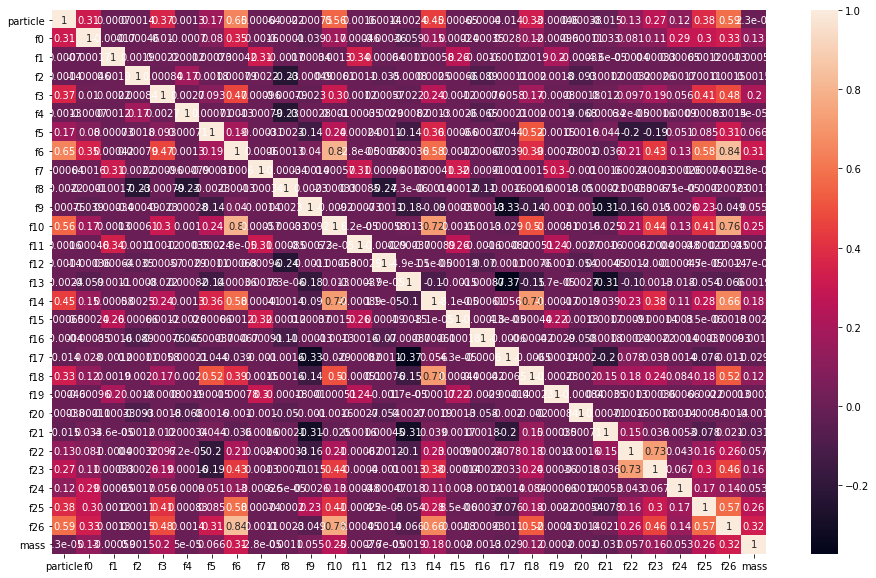

In [13]:
corrMatrix = df.corr()
fig, ax = plt.subplots(figsize=(16,10))

sns.heatmap(corrMatrix, annot=True)
plt.show()

In [14]:
#pip install yellowbrick

In [15]:
cl3 = df.drop(['particle'], axis=1)
vif_data = pd.DataFrame()
vif_data["feature"] = cl3.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(cl3.values, i)
                          for i in range(len(cl3.columns))]
print(vif_data)

   feature       VIF
0       f0  1.430251
1       f1  1.219331
2       f2  1.113360
3       f3  1.532627
4       f4  1.092052
5       f5  1.879128
6       f6  5.309298
7       f7  1.284082
8       f8  1.233366
9       f9  2.956112
10     f10  4.379698
11     f11  1.230877
12     f12  1.097304
13     f13  2.896539
14     f14  3.364852
15     f15  1.186992
16     f16  1.055913
17     f17  2.829007
18     f18  2.591824
19     f19  1.146233
20     f20  1.035508
21     f21  2.416028
22     f22  2.502848
23     f23  3.023643
24     f24  1.118039
25     f25  1.902337
26     f26  5.089418
27    mass  1.017602


In [16]:
sorted_mat = abs(corrMatrix.unstack().sort_values())
  
sorted_mat2 = pd.DataFrame(sorted_mat)

#sorted_mat2.where(sorted_mat2 > 1)
sorted_mat3 = sorted_mat2.loc[(sorted_mat2[0] > 0.7)]

In [17]:
sorted_mat3.loc[sorted_mat3[0] < 1]

,,0
f14,f18,0.714854
f18,f14,0.714854
f14,f10,0.721323
f10,f14,0.721323
f22,f23,0.727090
f23,f22,0.727090
f10,f26,0.760129
f26,f10,0.760129
f6,f10,0.800114
f10,f6,0.800114


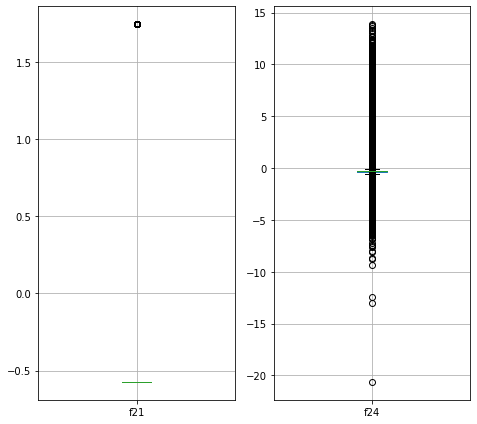

In [18]:
# Visualize Outliers

fig, axs = plt.subplots(2,1,figsize=(10,6))
plt.subplot(1, 3, 1)
df.boxplot(column=['f21'])
plt.subplot(1, 3, 2)
df.boxplot(column=['f24'])
#plt.subplot(1, 3, 3)
#df.boxplot(column=['f21'])

plt.tight_layout()

In [19]:
cl3 = df.drop(['particle','f26','f21','f24'], axis=1)
vif_data = pd.DataFrame()
vif_data["feature"] = cl3.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(cl3.values, i)
                          for i in range(len(cl3.columns))]
print(vif_data)

   feature       VIF
0       f0  1.302825
1       f1  1.219331
2       f2  1.113355
3       f3  1.455138
4       f4  1.092045
5       f5  1.737106
6       f6  4.446841
7       f7  1.284072
8       f8  1.233359
9       f9  1.658916
10     f10  4.228517
11     f11  1.230877
12     f12  1.097297
13     f13  1.556804
14     f14  3.317488
15     f15  1.186974
16     f16  1.055909
17     f17  1.555412
18     f18  2.555113
19     f19  1.146226
20     f20  1.035500
21     f22  2.491103
22     f23  2.939036
23     f25  1.791615
24    mass  1.016386


<a id="3"></a>
## Modeling Preparations

Since the data set is balanced accuracy is a good determinant of the how well the model performed. In this study we are trying to predict if the outcome was a particle or not. We are not informed of the backround of this, we are not sure if the identification of the particle or not is the preffered outcome, since we are not certain of the preferred outcome and we do not know how severe this outcome would be if it is not achieved we do not have a critical metric however we will in addition to accuracy measure the precision, recall and f1 score, all else being equal we will use accuracy as the determining metric and f1 score as the second most important metric since it measuers the balance of how well the precision and recall did.<br>

Metrics 
1. Accuracy (determining metric)
2. f1 score
3. Precision
4. Recall


<b>Models</b>
1. Tensorflow

We will be looking at two tensorflow models one will serve as the base model and the second model will be compared to it. In the second model some hyperparamteres will be adjusted we will see if there are any differences. 

Tuned parameters:
1. **Reduced neurons:** Accuracy was reduced for very small amounts of neurons, but also lowered at very high amounts of neurons including the additional runtime. An amount of neurons in between these ranges was found to have better results.
2. **Reduced batch size:** Similarly a middle ground to changes in batch size also provided a better accuracy at some cost to runtime.


In [20]:
from yellowbrick.model_selection import FeatureImportances
from sklearn.model_selection import train_test_split

X = df.drop(['particle','f26','f21','f24'], axis=1)
y = df['particle']

#splitting data into train/test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [21]:
from sklearn.preprocessing import StandardScaler

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) 

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply to the test set

In [22]:
X.shape

(700000, 25)

In [23]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import InputLayer

model1 = tf.keras.Sequential()

model1.add(InputLayer(input_shape=(25,))) #adds input layer
model1.add(tf.keras.layers.Dense(1000, activation='sigmoid'))#adds layer with 100 neurons
model1.add(tf.keras.layers.Dense(500, activation='sigmoid'))
model1.add(tf.keras.layers.Dense(1, activation='sigmoid')) #output layer

#model.add(InputLayer(input_shape=shape, name=name))

model1.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy']) #loss type for categorical

In [24]:
#pip install keras 

In [25]:
%%time
safety = EarlyStopping(monitor='val_loss', patience=1)
history = model1.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), epochs=1000, batch_size=500, callbacks=[safety])

Train on 469000 samples, validate on 231000 samples
Epoch 1/1000
469000/469000 [==============================] - 26s 56us/step - loss: 0.3742 - acc: 0.8268 - val_loss: 0.3464 - val_acc: 0.8405
Epoch 2/1000
469000/469000 [==============================] - 27s 57us/step - loss: 0.3352 - acc: 0.8429 - val_loss: 0.3368 - val_acc: 0.8428
Epoch 3/1000
469000/469000 [==============================] - 27s 57us/step - loss: 0.3304 - acc: 0.8450 - val_loss: 0.3333 - val_acc: 0.8428
Epoch 4/1000
469000/469000 [==============================] - 27s 57us/step - loss: 0.3282 - acc: 0.8457 - val_loss: 0.3275 - val_acc: 0.8467
Epoch 5/1000
469000/469000 [==============================] - 27s 58us/step - loss: 0.3253 - acc: 0.8474 - val_loss: 0.3198 - val_acc: 0.8500
Epoch 6/1000
469000/469000 [==============================] - 28s 59us/step - loss: 0.3155 - acc: 0.8515 - val_loss: 0.3119 - val_acc: 0.8532
Epoch 7/1000
469000/469000 [==============================] - 28s 59us/step - loss: 0.3105 - acc

In [26]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

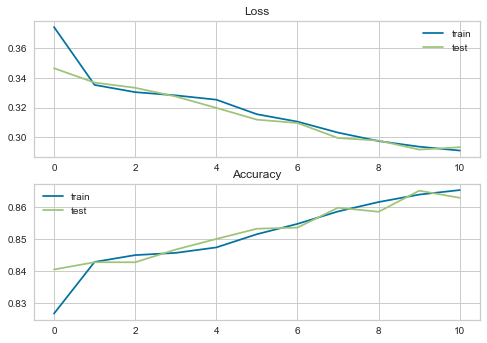

Train Accuracy: 0.865, Test Accuracy: 0.863


In [27]:
# evaluate the model1
_, train_acc = model1.evaluate(X_train_scaled, y_train, verbose=0)
_, test_acc = model1.evaluate(X_test_scaled, y_test, verbose=0)
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['acc'], label='train')
pyplot.plot(history.history['val_acc'], label='test')
pyplot.legend()
pyplot.show()

print('Train Accuracy: %.3f, Test Accuracy: %.3f' % (train_acc, test_acc))

In [28]:
# predict probabilities for test set
yhat_probs = model1.predict(X_test_scaled,verbose=0)
yhat_classes = model1.predict_classes(X_test_scaled, verbose=0)

In [29]:
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]

In [30]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

Accuracy: 0.862749
Precision: 0.871284
Recall: 0.852522
F1 score: 0.861801


In [31]:
#tuned parameters: reduced neurons, reduced batch size (showed increases in acc on smaller subset of data), 
                   #too much reduction also lowered acc suggesting a sweetspot
    
model2 = tf.keras.Sequential()

model2.add(InputLayer(input_shape=(25,))) #adds input layer
model2.add(tf.keras.layers.Dense(100, activation='sigmoid'))#adds layer with 100 neurons
model2.add(tf.keras.layers.Dense(50, activation='sigmoid'))
model2.add(tf.keras.layers.Dense(1, activation='sigmoid')) #output layer

model2.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy']) #loss type for categorical

In [32]:
%%time
safety = EarlyStopping(monitor='val_loss', patience=1)
history = model2.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), epochs=1000, batch_size=50, callbacks=[safety])

Train on 469000 samples, validate on 231000 samples
Epoch 1/1000
469000/469000 [==============================] - 12s 26us/step - loss: 0.3429 - acc: 0.8410 - val_loss: 0.3319 - val_acc: 0.8443 0.3432 - acc: 0.84 - ETA: 0s - loss: 0.3433 - acc
Epoch 2/1000
469000/469000 [==============================] - 12s 25us/step - loss: 0.3135 - acc: 0.8516 - val_loss: 0.3062 - val_acc: 0.8543
Epoch 3/1000
469000/469000 [==============================] - 12s 25us/step - loss: 0.2985 - acc: 0.8592 - val_loss: 0.2940 - val_acc: 0.8606
Epoch 4/1000
469000/469000 [==============================] - 12s 25us/step - loss: 0.2919 - acc: 0.8632 - val_loss: 0.2916 - val_acc: 0.8635
Epoch 5/1000
469000/469000 [==============================] - 12s 25us/step - loss: 0.2877 - acc: 0.8662 - val_loss: 0.2867 - val_acc: 0.8664
Epoch 6/1000
469000/469000 [==============================] - 12s 25us/step - loss: 0.2847 - acc: 0.8686 - val_loss: 0.2843 - val_acc: 0.8686
Epoch 7/1000
469000/469000 [==================

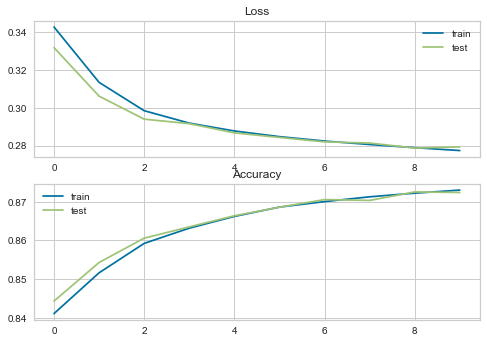

Train Accuracy: 0.873, Test Accuracy: 0.872


In [33]:
# evaluate the model2
_, train_acc = model2.evaluate(X_train_scaled, y_train, verbose=0)
_, test_acc = model2.evaluate(X_test_scaled, y_test, verbose=0)
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['acc'], label='train')
pyplot.plot(history.history['val_acc'], label='test')
pyplot.legend()
pyplot.show()

print('Train Accuracy: %.3f, Test Accuracy: %.3f' % (train_acc, test_acc))

In [34]:
# predict probabilities for test set
yhat_probs = model2.predict(X_test_scaled,verbose=0)
yhat_classes = model2.predict_classes(X_test_scaled, verbose=0)

In [35]:
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]

In [36]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

Accuracy: 0.872407
Precision: 0.852355
Recall: 0.902075
F1 score: 0.876510


<a id="4"></a>
## Modeling Building and Evaluation
1. Model 1 (Tensorflow Base Model)<br>
Accuracy: 0.862749<br>
Precision: 0.871284<br>
Recall: 0.852522<br>
F1 score: 0.861801<br>
<br>
2. Model 2 (Tensorflow with Parameter Tuning)<br>
Accuracy: 0.872407<br>
Precision: 0.852355<br>
Recall: 0.902075<br>
F1 score: 0.876510<br>

The tuned model had better performance with a 10% improvement in our critical metric accuracy and a 5% improvement to Recall. The base model appears to perform slightly better with precision, however this was only a 2% difference and likely insignificant or due to random chance. Since the tuned model performed better in our two main metrics which were Accuracy and f1 score we will assume that the best model is the tuned model. 

<a id="5"></a>
## Model Intepretability & Explainability

1. Run Logistic regression model and interprete coefficients
2. Remove the 3 variables that have high coeficient weights one at a time

We ran a Logistic regrssion model to use the variables applied in our model to check if we could see the most important variables. We found that the top 3 variables were f6 with a weight of 1.648, f0 with a weight of 0.543, and f10 with a weight of 0.514. 
1. Removing f6 <br>
Train Accuracy: 0.859, Test Accuracy: 0.859<br>
2. Removing f0 <br>
Train Accuracy: 0.857, Test Accuracy: 0.856<br>
2. Removing f10 <br>
Train Accuracy: 0.871, Test Accuracy: 0.870<br>

With the removal of these 3 major determining variables it was expected that the accuracy of the model would be reduced significantly. As each varibale was removed one by one. with f6 being removed the accuracy reduced from 0.8724 to 0.859 so this is a significant reduction we can say that f6 has a major effect on the accuracy. Also when f0 was removed from the model the accuracy reduced from 0.8724 to 0.856 that was also a significant reduction in the accuracy,  However after removing the f10 there was only a small reduction in the overall accuracy (1 to 2%) in constrast to the tuned model. So we see that it seems f6 and f0 are features that significantly affect the model however f10 does not have large impact on the model.

### Linear Regression Model interpretability check

In [38]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()

In [39]:
logisticRegr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [40]:
predictions = logisticRegr.predict(X_test)

### Coefficient Visualization

In [41]:
zip_vars = zip(logisticRegr.coef_.T,X.columns) # combine attributes
zip_vars = sorted(zip_vars, reverse=False)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) 

f23 has weight of -0.06553601886962984
f22 has weight of -0.044096579402497366
f15 has weight of -0.0045369111713879015
f8 has weight of -0.004378919582821429
mass has weight of -0.002680006743193522
f7 has weight of -0.0025690758958467736
f16 has weight of 0.0010918753196350172
f19 has weight of 0.0011042700624808997
f2 has weight of 0.001462195631625857
f4 has weight of 0.0017235121553572557
f1 has weight of 0.00248221748170492
f12 has weight of 0.0029775074447761546
f11 has weight of 0.0032695226990210927
f20 has weight of 0.0046824584867983556
f5 has weight of 0.009063482979401506
f17 has weight of 0.03684333756622092
f9 has weight of 0.0652419951676244
f13 has weight of 0.07543629569086757
f25 has weight of 0.11287178621189296
f18 has weight of 0.1456340039412177
f14 has weight of 0.22145371952599635
f3 has weight of 0.5060861065009058
f10 has weight of 0.5143619679121016
f0 has weight of 0.5436197088434668
f6 has weight of 1.6488004622345798


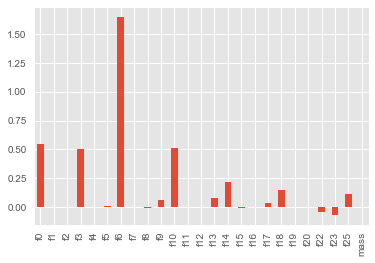

In [42]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

weights = pd.Series(logisticRegr.coef_[0],index=X.columns)
weights.plot(kind='bar')
plt.show()

### Removal of critical coefficients for altered performance check

### Remove Variable f6

In [43]:
from yellowbrick.model_selection import FeatureImportances
from sklearn.model_selection import train_test_split

X = df.drop(['particle','f26','f21','f24','f6'], axis=1)
y = df['particle']

#splitting data into train/test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [44]:
from sklearn.preprocessing import StandardScaler

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) 

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply to the test set

In [45]:
X.shape

(700000, 24)

In [46]:
model3 = tf.keras.Sequential()

model3.add(InputLayer(input_shape=(24,))) #adds input layer
model3.add(tf.keras.layers.Dense(100, activation='sigmoid'))#adds layer with 100 neurons
model3.add(tf.keras.layers.Dense(50, activation='sigmoid'))
model3.add(tf.keras.layers.Dense(1, activation='sigmoid')) #output layer

model3.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy']) #loss type for categorical

In [47]:
%%time
safety = EarlyStopping(monitor='val_loss', patience=1)
history = model3.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), epochs=1000, batch_size=500, callbacks=[safety],verbose=0)

CPU times: user 1min 8s, sys: 7.93 s, total: 1min 16s
Wall time: 43.1 s


In [48]:
# evaluate the model1
_, train_acc = model3.evaluate(X_train_scaled, y_train, verbose=0)
_, test_acc = model3.evaluate(X_test_scaled, y_test, verbose=0)

print('Train Accuracy: %.3f, Test Accuracy: %.3f' % (train_acc, test_acc))

Train Accuracy: 0.859, Test Accuracy: 0.859


### Remove Variable f0

In [49]:
X = df.drop(['particle','f26','f21','f24','f0'], axis=1)
y = df['particle']

#splitting data into train/test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [50]:
# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) 

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply to the test set

In [51]:
X.shape

(700000, 24)

In [52]:
%%time
safety = EarlyStopping(monitor='val_loss', patience=1)
history = model3.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), epochs=1000, batch_size=500, callbacks=[safety],verbose=0)

CPU times: user 22.5 s, sys: 2.6 s, total: 25.1 s
Wall time: 13.8 s


In [53]:
# evaluate the model1
_, train_acc = model3.evaluate(X_train_scaled, y_train, verbose=0)
_, test_acc = model3.evaluate(X_test_scaled, y_test, verbose=0)

print('Train Accuracy: %.3f, Test Accuracy: %.3f' % (train_acc, test_acc))

Train Accuracy: 0.857, Test Accuracy: 0.856


### Remove Variable f10

In [54]:
from yellowbrick.model_selection import FeatureImportances
from sklearn.model_selection import train_test_split

X = df.drop(['particle','f26','f21','f24','f10'], axis=1)
y = df['particle']

#splitting data into train/test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [55]:
from sklearn.preprocessing import StandardScaler

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) 

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply to the test set

In [56]:
X.shape

(700000, 24)

In [57]:
%%time
safety = EarlyStopping(monitor='val_loss', patience=1)
history = model3.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), epochs=1000, batch_size=500, callbacks=[safety],verbose=0)

CPU times: user 40.1 s, sys: 5.22 s, total: 45.4 s
Wall time: 23.4 s


In [58]:
# evaluate the model1
_, train_acc = model3.evaluate(X_train_scaled, y_train, verbose=0)
_, test_acc = model3.evaluate(X_test_scaled, y_test, verbose=0)

print('Train Accuracy: %.3f, Test Accuracy: %.3f' % (train_acc, test_acc))

Train Accuracy: 0.871, Test Accuracy: 0.870


## Result Summary


In [4]:
import pandas as pd
Model_compare = pd.DataFrame(
{'Model': ['Tensorflow Base Model','Tensorflow with Parameter Tuning','f6 Coefficient Effect','f0 Coefficient Effect','f10 Coefficient Effect'],
'Runtime': ['1.00','1.06','1.05','0.36','1.05'],
'Training Accuracy': ['0.865','0.873','0.859','0.857','0.871'],
'Test Accuracy': ['0.861','0.872','0.859','0.856','0.870'],
})
pd.set_option("max_colwidth", 3000)

Model_compare

,Model,Runtime,Training Accuracy,Test Accuracy
0,Tensorflow Base Model,1.00,0.865,0.861
1,Tensorflow with Parameter Tuning,1.06,0.873,0.872
2,f6 Coefficient Effect,1.05,0.859,0.859
3,f0 Coefficient Effect,0.36,0.857,0.856
4,f10 Coefficient Effect,1.05,0.871,0.870


<a id="6"></a>
## Conclusions

We see that there was a large difference between the base model and hyperparameter tuned model acccuracy (from 0.862 to 0.872) also the the f1 score is the balance between the precision and recall in which the tuned model also performed better (from 0.861 to 0.876) , so we concluded that reduction in batch size and neurons significantly improve the performance of the model. After looking at the coefficients we see that out of the 3 variables identified to significantly affect the model, f10 seems to have the least impact on the model as it had little to no impact. We can advise our clients to use a model without the f10 feature and look for more features similar to this that can be removed to improve the accuracy of the model. While it was noted that f0 and f6 significantly improved the accuracy of the model so this information can be used and improvd upon to help identify particles.